In [1]:
import tensorflow as tf
import keras
import os
import json
import numpy as np
import cv2
import imgaug as ia
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug.augmenters as iaa

Using TensorFlow backend.


# Dataset

In [5]:
class Dataset(keras.utils.Sequence):
    def __init__(self, data_dir, out_size, batchsize, augment=True):
        self.batchsize = batchsize
        self.data_dir = data_dir
        self.out_size = out_size
        self.augment = augment
        self.load_meta()
        
        if augment:
            self.aug_seq = iaa.Sequential([
                    iaa.Fliplr(0.5),
                    iaa.Affine(scale=(0.7, 1.3), rotate=(-45, 45)),
                    iaa.contrast.LinearContrast((0.7, 1.3)),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.blur.GaussianBlur((0.1, 0.5)),
                    iaa.imgcorruptlike.GaussianNoise((1,4)),
                    iaa.Noop(),
            ], random_order=True)
        
    def load_meta(self):
        with open(os.path.join(self.data_dir, 'via_region_data.json')) as f:
            self.meta = json.load(f)['_via_img_metadata']
        self.images_names = list(self.meta.keys())
        img_to_del = []
        for img_name in self.images_names:
            try:
                mask = self.get_mask(img_name, (10000, 10000))
            except KeyError:
                img_to_del.append(img_name)
        for img_name in img_to_del:
            self.images_names.remove(img_name)
        
    def get_mask(self, img_name, shape):
        img_meta = self.meta[img_name]
        mask = np.zeros(shape, dtype=np.uint8)
        for reg in img_meta['regions']:
            polys = []
            for x, y in zip(reg['shape_attributes']['all_points_x'], reg['shape_attributes']['all_points_y']):
                polys.append([x, y])
            cv2.fillPoly(mask, [np.array(polys,dtype=np.int32)], 1)
        # mask = mask.astype(np.int8)
        return mask
        
        
    def __len__(self):
        return int(np.ceil(len(self.images_names) / self.batchsize))
    
    def __getitem__(self, index):
        sel_imgs = self.images_names[index * self.batchsize: (index + 1) * self.batchsize]
        
        x = []
        y = []
        
        for img_name in sel_imgs:
            img = cv2.imread(os.path.join(self.data_dir, img_name))
            mask = self.get_mask(img_name, img.shape[:2])

            img = cv2.resize(img, self.out_size, cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.out_size, cv2.INTER_NEAREST)

            mask = mask[:, :, np.newaxis]

            if self.augment:
                img, mask = self.aug_seq(image=img, 
                                         segmentation_maps=SegmentationMapsOnImage(mask, shape=img.shape))
                mask = mask.get_arr()

            x.append(img)
            y.append(mask)
            
        x = np.array(x, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
            
            
        x = x / 255.
        
        return x, y
        
    

In [6]:
train_ds = Dataset('data/autoriaNumberplateDataset-2018-11-20/train/', out_size=(1024, 1024), batchsize=1, augment=True)
val_ds = Dataset('data/autoriaNumberplateDataset-2018-11-20/val/', out_size=(1024, 1024), batchsize=1, augment=False)

In [9]:
train_ds[10][1].shape

(1, 1024, 1024, 1)

# Model

In [10]:
input_layer = keras.layers.Input(shape=(1024, 1024, 3), name = 'input_layer')

In [11]:
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
    if(conv_type == 'ds'):
        x = keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
    else:
        x = keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)  
  
    x = keras.layers.BatchNormalization()(x)
  
    if (relu):
        x = keras.layers.Activation('relu')(x)
  
    return x

In [12]:
lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    tchannel = keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = keras.layers.add([x, inputs])
    return x

In [14]:
def bottleneck_block(inputs, filters, kernel, t, strides, n):
    x = _res_bottleneck(inputs, filters, kernel, t, strides)
  
    for i in range(1, n):
        x = _res_bottleneck(x, filters, kernel, t, 1, True)

    return x

In [15]:
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)

In [16]:
def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = 32
    h = 32

    for bin_size in bin_sizes:
        x = keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h)))(x)

        concat_list.append(x)

    return keras.layers.concatenate(concat_list)

In [17]:
gfe_layer = pyramid_pooling_block(gfe_layer, [2,4,6,8])

In [18]:
ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

In [19]:
ff_layer2 = keras.layers.UpSampling2D((4, 4))(gfe_layer)
# ff_layer2 = keras.layers.DepthwiseConv2D(128, strides=(1, 1), depth_multiplier=1, padding='same')(ff_layer2)
# ff_layer2 = keras.layers.BatchNormalization()(ff_layer2)
# ff_layer2 = keras.layers.Activation('relu')(ff_layer2)
ff_layer2 = keras.layers.Conv2D(128, kernel_size=1, strides=1, padding='same', activation=None)(ff_layer2)

In [20]:
ff_final = keras.layers.add([ff_layer1, ff_layer2])
ff_final = keras.layers.BatchNormalization()(ff_final)
ff_final = keras.layers.Activation('relu')(ff_final)

In [21]:
classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = keras.layers.BatchNormalization()(classifier)
classifier = keras.layers.Activation('relu')(classifier)

classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = keras.layers.BatchNormalization()(classifier)
classifier = keras.layers.Activation('relu')(classifier)

classifier = conv_block(classifier, 'conv', 1, (1, 1), strides=(1, 1), padding='same', relu=False)

classifier = keras.layers.Dropout(0.3)(classifier)

classifier = keras.layers.UpSampling2D((8, 8))(classifier)
classifier = keras.layers.Activation('sigmoid')(classifier)

In [22]:
fast_scnn = keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')

In [23]:
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

# Training

In [24]:
fast_scnn.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(momentum=0.9, lr=0.045),
                  metrics=['binary_accuracy']
                 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [54]:
fast_scnn.fit_generator(train_ds, 
                       epochs=3,
                       validation_data=val_ds,
                       workers=5,
                       max_queue_size=5,
                       shuffle=True)

Epoch 1/3
1124/1124 [==============================] - 216s 192ms/step - loss: 0.2331 - binary_accuracy: 0.9914 - val_loss: 1.0067 - val_binary_accuracy: 0.8348
Epoch 2/3
1124/1124 [==============================] - 211s 187ms/step - loss: 0.2206 - binary_accuracy: 0.9943 - val_loss: 0.2040 - val_binary_accuracy: 0.9736
Epoch 3/3
1124/1124 [==============================] - 210s 187ms/step - loss: 0.2198 - binary_accuracy: 0.9944 - val_loss: 0.0391 - val_binary_accuracy: 0.9943


# Results

In [93]:
x, y = val_ds[100]

In [94]:
y_pred = fast_scnn.predict(x)

In [95]:
y_pred = np.where(y_pred > 0.5, 1, 0).astype(np.int8)

In [96]:
import imgaug as ia
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [97]:
segmap_true = SegmentationMapsOnImage(y[0].astype(np.int8), shape=x[0].shape)
segmap_pred = SegmentationMapsOnImage(y_pred[0], shape=x[0].shape)

In [98]:
img = (x[0, :, :] * 255).astype(np.uint8)
img = img[:, :, (2,1,0)]
img.shape

(1024, 1024, 3)

In [99]:
cells = []
cells.append(img)
cells.append(segmap_true.draw_on_image(img)[0])
cells.append(segmap_pred.draw_on_image(img)[0])

In [100]:
grid_image = ia.draw_grid(cells, cols=3)

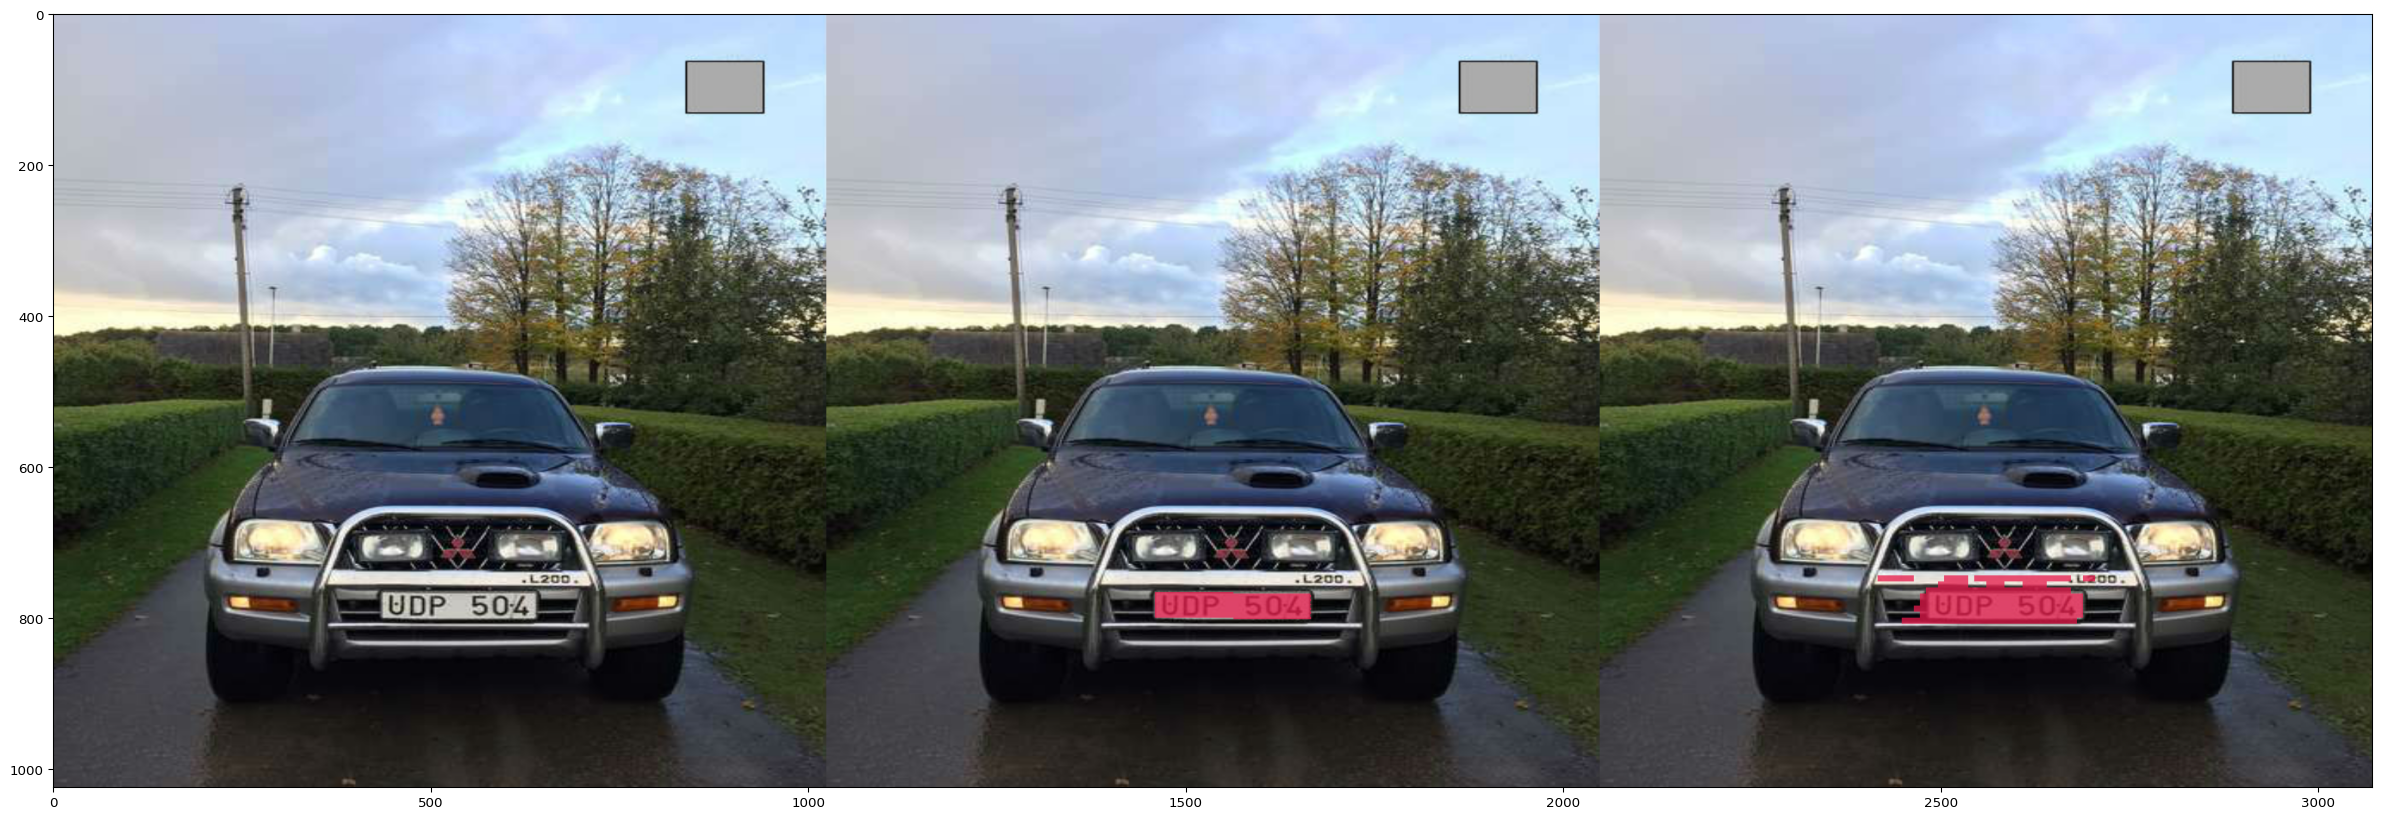

In [101]:
ia.imshow(grid_image)

In [102]:
iou = 2 * (y[0].astype(np.int8) * y_pred[0]).sum() / (y[0].astype(np.int8).sum() + y_pred[0].sum()) 
iou

0.6972127531582113